# Analiza zbioru danych dotyczącego cen smartfonów

Projekt ten ma na celu przeprowadzenie analizy eksploracyjnej oraz wykonanie regresji liniowej na zbiorze danych dotyczących smartfonów.

Link do zbioru: https://www.kaggle.com/datasets/swahajraza/a-dataset-of-smartphone-specifications-and-prices

# Analiza zbioru

## Import bibliotek

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle          # używana do zapisu modelu

## Wczytanie zbioru

In [2]:
df = pd.read_csv('smartphone_specifications_and_prices.csv')

df

,brand_name,model,display,front_camera,rare_camera,processor,battery_capacity,ram,internal_storage,price
0,SAMSUNG,Samsung S24 Ultra,"6.8"" (120Hz)",40MP,108MP + 10MP + 10MP + 12MP,Exynos,5000 mAh,8.0,128,334999.0
1,SAMSUNG,Samsung S24 Plus,"6.6"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,4500 mAh,8.0,128,189999.0
2,SAMSUNG,Samsung Zero,"6.41"" (120Hz)",32 MP,12 MP + 8 MP + 12 MP,Snapdragon 888 5G,4500 mAh,8.0,256,112999.0
3,SAMSUNG,Samsung S24,"6.1"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,3700 mAh,8.0,128,249999.0
4,SAMSUNG,Samsung A05s,"6.5"" (90Hz)",5MP,50MP + 2MP + 2MP,Exynos,5000 mAh,4.0,64,24999.0
...,...,...,...,...,...,...,...,...,...,...
1251,OPPO,Oppo A37,"5.0""",5 MP,8 MP,Snapdragon 410,2630mAh,2.0,16,88415.0
1252,OPPO,Oppo F1,"5.0""",8 MP,13 MP,Snapdragon 616,-,3.0,16,35999.0
1253,OPPO,Oppo A31,"4.5""",5 MP,8 MP,Snapdragon 410,2000mAh,1.0,8,88415.0
1254,OPPO,Oppo Reno 4 SE,"6.43""",32 MP,48 MP + 8 MP + 2 MP,Dimensity 720,4300mAh,8.0,128,88415.0


## Dodanie atrybutu 'score' poprzez połączenie ze zbiorem danych

Atrybut *score* opsiuje ogólną ocenę procesora, ze strony https://nanoreview.net/en/soc-list/rating

In [3]:
dd = pd.read_csv('../web-scraping/extra_data.csv')

pd.merge(df, dd, on = 'processor')

,brand_name,model,display,front_camera,rare_camera,processor,battery_capacity,ram,internal_storage,price,score
0,SAMSUNG,Samsung A54,"6.5"" (90Hz)",32 MP,64 MP + 12 MP + 1125 MP + 5 MP,Snapdragon 720G,4500 mAh,8.0,128,59999.0,38
1,SAMSUNG,Samsung A54 256GB,"6.5"" (90Hz)",32 MP,64 MP + 12 MP + 1125 MP + 5 MP,Snapdragon 720G,4500 mAh,8.0,256,65999.0,38
2,SAMSUNG,Samsung A73,"6.7"" (90Hz)",32 MP,108MP + 8MP + 2MP + 2MP,Snapdragon 720G,5000 mAh,8.0,128,67999.0,38
3,XIAOMI,Poco M2 Pro,"6.67""",16 MP,48 MP + 8 MP + 5 MP + 2 MP,Snapdragon 720G,5000mAh,4.0,64,31999.0,38
4,XIAOMI,Poco M2 Pro 6GB Ram,"6.67""",16 MP,48 MP + 8 MP + 5 MP + 2 MP,Snapdragon 720G,5000mAh,6.0,128,37999.0,38
...,...,...,...,...,...,...,...,...,...,...,...
206,OPPO,Oppo A5 2020,"6.5""",8 MP,12 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,3.0,64,27999.0,28
207,OPPO,Oppo A5 2020 4GB Ram,"6.5""",8 MP,12 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,4.0,64,31999.0,28
208,OPPO,Oppo A9 2020,"6.5""",16 MP,48 MP + 8 MP + 2 MP + 2 MP,Snapdragon 665,5000mAh,8.0,128,37999.0,28
209,OPPO,Oppo Reno 4 SE,"6.43""",32 MP,48 MP + 8 MP + 2 MP,Dimensity 720,4300mAh,8.0,128,88415.0,37


## Usunięcie błędów w danych

In [4]:
df.loc[df.model.isin(['iPhone 14', 'iPhone 14 128GB', 'iPhone 14 256GB']), 'processor'] = 'A15 Bionic'
df.loc[df.model == 'iPhone 15 Plus', 'price'] = 349999
df.loc[df.model == 'iPhone 15 Pro', 'battery_capacity'] = '3274'
df.loc[df.model == 'iPhone 15 Pro', 'internal_storage'] = 256
df.loc[df.model.str.contains('Samsung S23'), 'processor'] = 'Snapdragon 8 Gen 2'

Jak można zauważyć, usunęło to bardzo dużą ilość danych. Głównie przez braki w tych danych lub kompatybilność zbioru danych z pliku extra_data.csv z rozważanym zbiorem.

## Poprawienie kompatybilności danych

In [5]:
def get_rid_of_5G(s):
    '''
    funkcja usuwa z ciągu znaków znaki ' 5G'
    '''
    if '5G' in s:
        if '+ 5G' in s:
            return s.replace('+ 5G', '')
        else: 
            return s.replace(' 5G', '')
    return s

df['processor'] = df['processor'].astype(str)
# print(df.dtypes)
df['processor'] = df['processor'].apply(get_rid_of_5G)

Naprawienie problemu z nazwą 'Apple Bionic Ax' , gdzie x > 11, ponieważ w nazwach procesora występują nazwy 'Bionic Ax'.

In [6]:
def get_rid_of_Apple_in_processor_name(s):
    words = s.split(' ')
    if len(words) > 2 & ('Apple' in words):
        return s.replace('Apple ', '')
    else:
        return s
    
df['processor'] = df['processor'].apply(get_rid_of_Apple_in_processor_name)

Zamiana znaku '+' na 'Plus' - ze względu na sposób zapisu w zbiorze ze statystykimi procesorów

In [7]:
def get_rid_of_plus_sign(s):
    return s.replace('+', ' Plus')

df['processor'] = df['processor'].apply(get_rid_of_plus_sign)

Usunięcie powtarzających się 2 razy nazwy producenta procesora MediaTek

In [8]:
def replace_Mediatek_with_helio(s):
    if 'MediaTek' in s:
        if ('P' in s or 'G' in s) and not 'Helio' in s:
            return s.replace('MediaTek', 'Helio')
        return s.replace('MediaTek', '')
    if 'Mediatek' in s:
        if ('P' in s or 'G' in s) and not 'Helio' in s:
            return s.replace('Mediatek', 'Helio')
        return s.replace('Mediatek', '')
    return s

df['processor'] = df['processor'].apply(replace_Mediatek_with_helio)

In [9]:
def replace_Gen1_with_Gen_1(s):
    return s.replace('Gen1', 'Gen 1')

df['processor'] = df['processor'].apply(replace_Gen1_with_Gen_1)

In [10]:
def return_for_iPhone_12(s):
    if s == 'A14':
        return 'A14 Bionic'
    return s

df['processor'] = df['processor'].apply(return_for_iPhone_12)

Ustawienie procesorów dla konkretnych telefonów

In [11]:
def set_processor_for_iPhones(row):
    if 'iPhone 15 Pro' in row['model']:
        return 'A17 Pro'
    elif 'iPhone 15' in row['model']:
        return 'A16 Bionic'
    elif 'iPhone 6s' in row['model']:
        return 'Apple A9'
    elif row['model'] in ['iPhone SE', 'iPhone SE 32GB', 'iPhone SE 64GB', 'iPhone SE 128GB']:
        return 'Apple A9'
    return row['processor']

df['processor'] = df.apply(set_processor_for_iPhones, axis = 1)

Usunięcie wyrazu, który zaczyna się na MT

In [12]:
df['processor'] = df['processor'].replace(r'\bMT\w*\b', '', regex = True)

In [13]:
def get_rid_of_last_first_space(s):
    return s.strip();

df['processor'] = df['processor'].apply(get_rid_of_last_first_space)

In [14]:
def get_rid_of_octa(s):
    if 'Octa' in s:
        return s.replace(' Octa', '')
    return s

df['processor'] = df['processor'].apply(get_rid_of_octa)

In [15]:
def add_G_to_snapdragon_750(s):
    if s == 'Snapdragon 750':
        return s+'G'
    return s

df['processor'] = df['processor'].apply(add_G_to_snapdragon_750)

Sprawdzenie jakie rezultaty daje teraz scalanie

In [16]:
df = pd.merge(df, dd, how = 'left', on = 'processor')
#print(dg[dg['brand_name'] == 'APPLE'])
print("Obiektów przed scaleniem: ", len(df))

df = df.dropna(how = "any")
print("Obiektów po scaleniu: ", len(df))


Obiektów przed scaleniem:  1256
Obiektów po scaleniu:  974


In [17]:
df.to_csv('good_data.csv', index = False)

## Oczyszczanie danych

Usunięcie nieprawidłowych rekordów

In [18]:
i = df[df.model == 'iPhone SE 4'].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone 14 Mini')].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone 12 Flip')].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone Flip')].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone SE Plus')].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone SE 3')].index
df = df.drop(i)

i = df[df.model.str.contains('iPhone 12s')].index
df = df.drop(i)

Zamiana atrybutu opisowego *rear_camera* na atrybuty ilościowe. Rozdzielenie atrybututu *rear_camera* na *main_camera* - główny obiektyw, *sum_MP* - sumę megapikseli matryc, i *num_cameras* - liczbę obiektywów.

In [19]:
def count_integers(s):
    '''
    funkcja zwraca ilość wystąpień cyfr <= 200
    w ciągu oraz ich sumę liczb <= 200
    '''
    # rozdziel ciąg znaków na liczby
    words = re.findall(r'\d+', s)
    # znajdź błędy w danych (> 200 MP)
    i = 0
    sum = 0
    for w in words:
        if int(w) > 200:                # ze względu na błędy w danych
            i = i - 1
        else:
            sum = sum + int(w)
    # zlicz słowa, które są liczbami
    ret = len(words) + i
    return pd.Series([ret, sum])

Warunek, na cyfry wartość <=200 wynika z błędów danych, gdzie niektóre z kamer zostały źle przepisane

In [20]:
df[['num_cameras', 'sum_MP']] = df['rare_camera'].apply(count_integers)

Dodanie atrybutów *front_camera* - ilość megapikseli w kamerze w ekranie i *main_camera* - ilość megapikseli w głownej tylnej kamerze. W danych są one podawane jako pierwsze, w przypadku kamera z przodu najczęściej występuje jedna.

In [21]:
def find_first_number(s):
    ''' 
    funkcja zwraca pierwszą napotkaną liczbę
    w ciągu znaków
    '''
    words = re.findall(r'\d+', s)
    if len(words) > 0:
        return words[0]
    else:
        return 0

In [22]:
df['front_camera'] = df['front_camera'].apply(find_first_number)
df['main_camera']  = df['rare_camera'].apply(find_first_number)

df[['front_camera', 'main_camera']] = df[['front_camera', 'main_camera']].apply(pd.to_numeric)

# nie potrzebny już atrybut
df = df.drop(columns = 'rare_camera')

Usunięcie tabletów ze zbioru danych:

In [23]:
df = df[~df['model'].str.contains('Pad|Tab', na=False)]

Usunięcie kolumn, które nie posiadały żadnych zgodnych liczb

In [24]:
df = df[df.front_camera != 0]
df = df[df.sum_MP != 0]
df = df[df.main_camera != 0]

Obrobienie wartości pojemności baterii - tylko te rekordy, które zawierają 4 cyfrową liczbę. Jest tak, ponieważ pojemności baterii zwyczajowo dla smartfonów podaje się w tysiącach mAh, pozostałe wartości, albo są nie podane, albo są podane w Wh i dotyczą tabletów

In [25]:
df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]

df['battery_capacity'] = pd.to_numeric(df['battery_capacity'].str[-8:-3])

print("Liczba obiektów:", df.shape[0])

Liczba obiektów: 936


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_13680\4251574446.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]


Rozdzielenie atrybutu 'display' na rozmiar ekranu i jego częstotliwość odświeżania. Jeżeli częstotliwość nie została podana przyjmuje się wartość 60.

In [26]:
# atrybut 'display' ma wartości podane w formie: <liczba>" <ew. odświeżanie ekranu>
df[['screen_size', 'refresh_rate']] = pd.DataFrame(df['display'].str.split('"').tolist(), index = df.index)
df = df.drop(columns = 'display')

df['refresh_rate'] = df['refresh_rate'].apply(lambda x: '60' if x == ''  else x[2:-3])

Dodanie kolumny z oceną procesora pozbyło się co najmiej kilkadziesiąt rekordów, lecz pomogło to w pewien sposób ujednolicić zbiór do aktualnych specyfikacji smartfonów poprzez wyeliminowanie tych, które są za stare.

## Dodanie smartfonów do bazy

In [27]:
df.loc[-1] = ['APPLE', 'iPhone 14 Plus', 12, 'A15 Bionic', 4323, 6, 128, 199999, 89, 2, 24, 12, 6.7, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 14 Plus 256GB', 12, 'A15 Bionic', 4323, 6, 256, 209999, 89, 2, 24, 12, 6.7, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 14 Plus 512GB', 12, 'A15 Bionic', 4323, 6, 512, 219999, 89, 2, 24, 12, 6.7, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 256GB', 12, 'A16 Bionic', 3349, 6, 256, 349999, 94, 2, 60, 48, 6.1, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 512GB', 12, 'A16 Bionic', 3349, 6, 512, 399999, 94, 2, 60, 48, 6.1, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Plus 256GB', 12, 'A16 Bionic', 4383, 6, 256, 379999, 94, 2, 60, 48, 6.7, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Plus 512GB', 12, 'A16 Bionic', 4383, 6, 512, 439999, 94, 2, 60, 48, 6.7, '60']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Pro 256GB', 12, 'A17 Pro', 3274, 8, 256, 429999, 94, 3, 72, 48, 6.1, '120']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Pro 512GB', 12, 'A17 Pro', 3274, 8, 512, 485999, 94, 3, 72, 48, 6.1, '120']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Pro 1TB', 12, 'A17 Pro', 3274, 8, 1024, 539999, 94, 3, 72, 48, 6.1, '120']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Pro Max 1TB', 12, 'A17 Pro', 4441, 8, 1024, 555999, 94, 3, 72, 48, 6.7, '120']
df.index = df.index + 1
df = df.sort_index()

df.loc[-1] = ['APPLE', 'iPhone 15 Pro Max 512GB', 12, 'A17 Pro', 4441, 8, 1024, 495999, 94, 3, 72, 48, 6.7, '120']
df.index = df.index + 1
df = df.sort_index()

## Podstawowe statystyki danych

In [28]:
print("Liczba obiektów:", df.shape[0])
marki = df['brand_name'].unique()
print("Liczba marek:", marki.shape[0])
for i in list(marki):
    print("Obiektów marki", i, ": ", len(df[df['brand_name'] == i]))
print("Liczba atrybutów:", df.shape[1])
print("Ilość braków:", df.isnull().sum().sum())

Liczba obiektów: 948
Liczba marek: 5
Obiektów marki APPLE :  91
Obiektów marki SAMSUNG :  256
Obiektów marki XIAOMI :  353
Obiektów marki ONEPLUS :  71
Obiektów marki OPPO :  177
Liczba atrybutów: 14
Ilość braków: 0


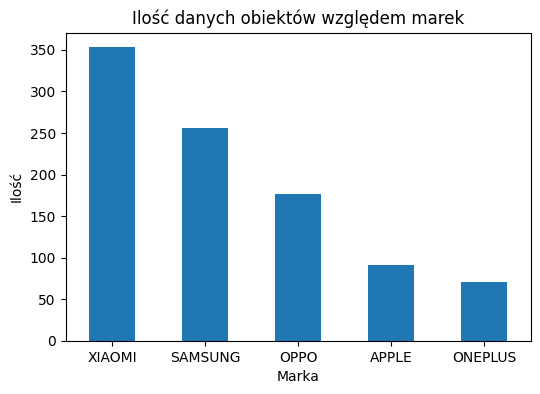

In [29]:
plt.figure(figsize=(6, 4))
df['brand_name'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów względem marek', fontsize = 12)
plt.xlabel('Marka', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Zbiór posiada 5 producentów smartfonów oraz nie posiada braków. Większość obiektów (smartfonów) jest marki XIAOMI. Jednocześnie każdy smartfon posiada 11 atrybutów ilościowych: 
* pamięć wewnętrzną - *internal_storage* 
* pamięć RAM - *ram*
* wielkość przekątnej ekranu - *screen_size*
* odświeżanie ekranu - *refresh_rate**
* pojemność baterii - *battery* 
* cenę - *price*
* punktację procesora (od 11 do 100) - *score*
* liczba obiektów (znajdujących się z tyłu) - *num_cameras*
* suma megapikseli kamer (znajdujących się z tyłu) - *sum_MP*
* liczba megapikseli kamery frontowej - *front_camera*
* liczba megapikseli kamery z tyłu - *main_camera*

*odświeżanie ekranu może być potraktowane jako atrybut kategoryczny porządkowy, ponieważ wartości odświeżania ekranu zwykle przyjmują wartości 60, 90, 120 Hz

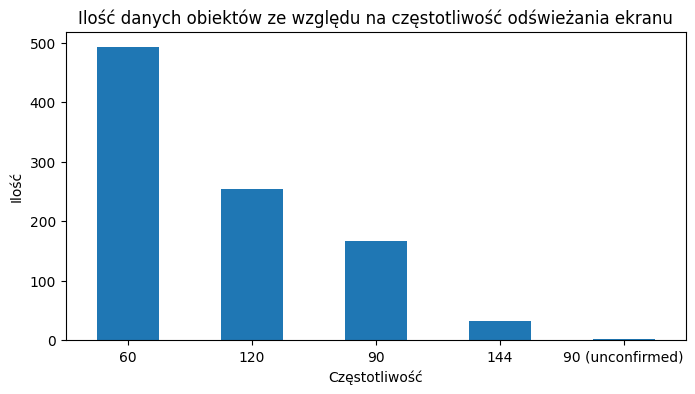

In [30]:
plt.figure(figsize=(8, 4))
df['refresh_rate'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Pozbycie się informacji '(unconfirmed)'

In [31]:
df['refresh_rate'] = df['refresh_rate'].apply(lambda x: x[:2] if '(' in x  else x)

df[['screen_size', 'refresh_rate']] = df[['screen_size', 'refresh_rate']].apply(pd.to_numeric)

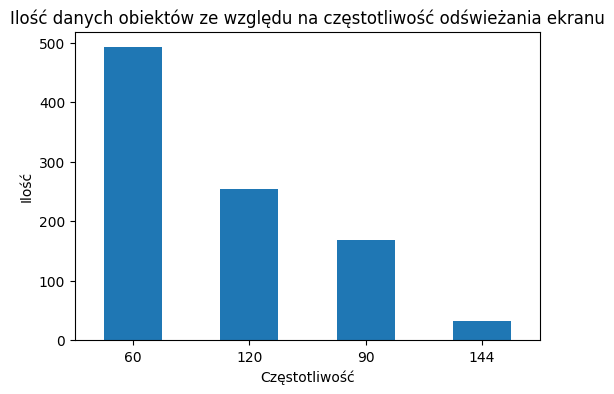

In [32]:
plt.figure(figsize=(6, 4))
df['refresh_rate'].value_counts().sort_values(ascending=0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

## Wykresy pudełkowe i skrzypcowe dla danych

In [33]:
# zresetowanie indeksów
df = df.reset_index()
df = df.drop(columns = ['index'])     # usunięcie starego indeksowania

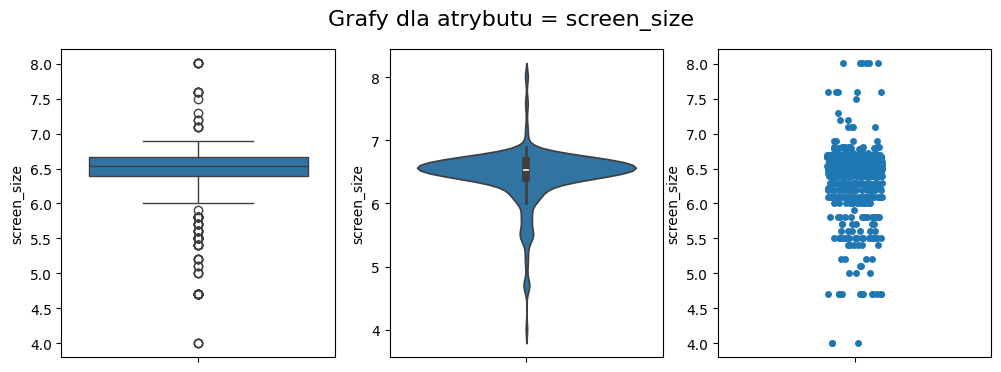

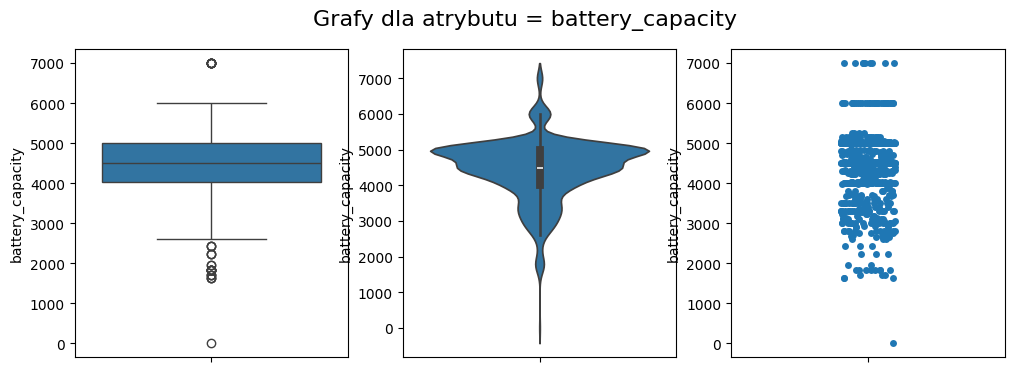

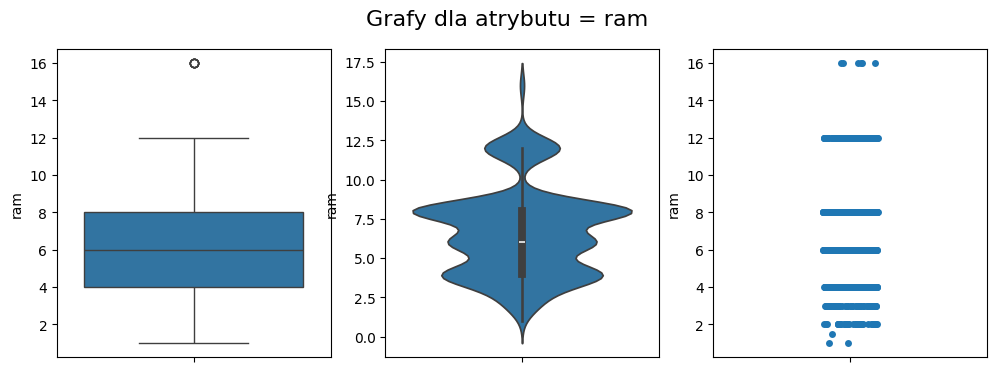

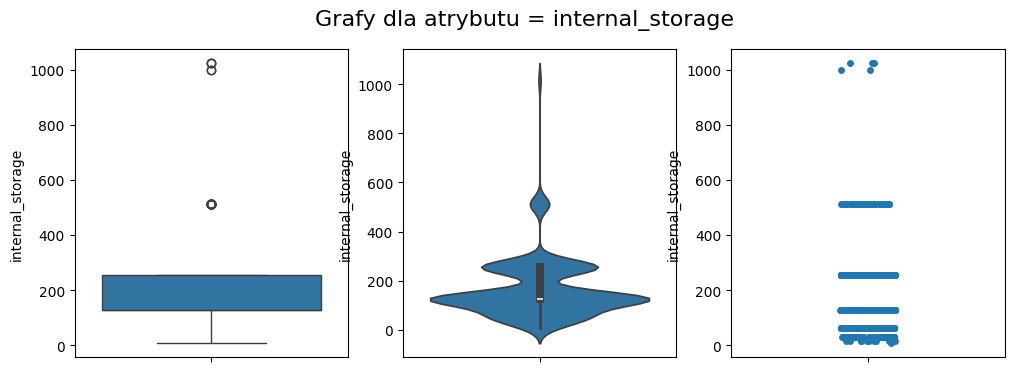

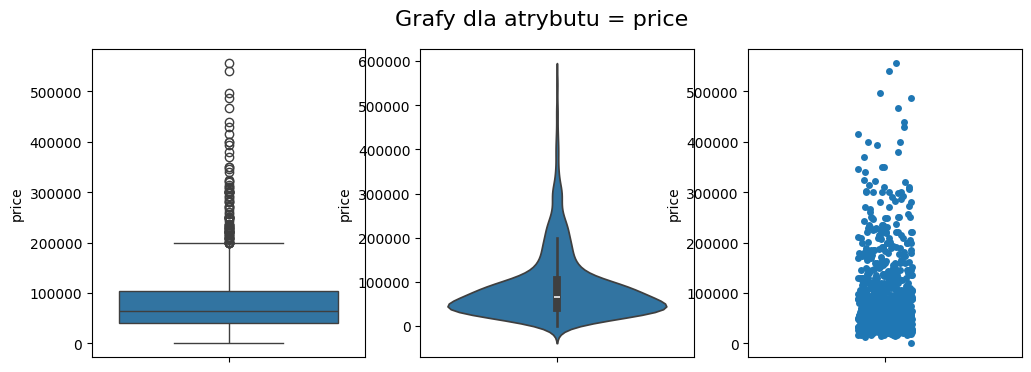

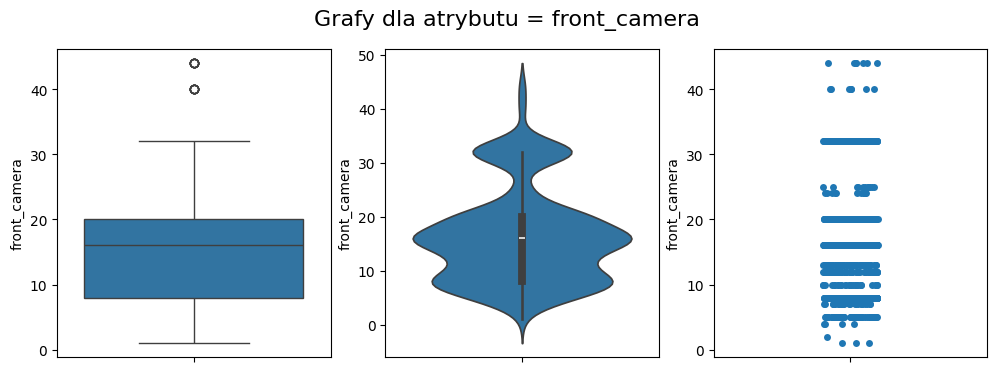

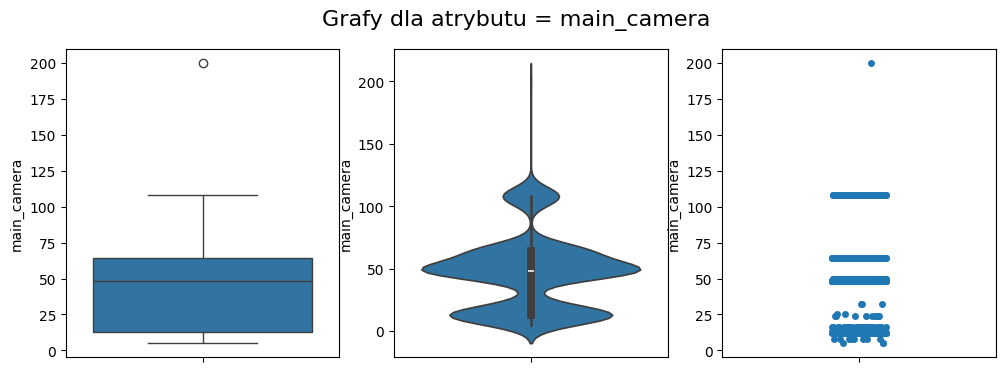

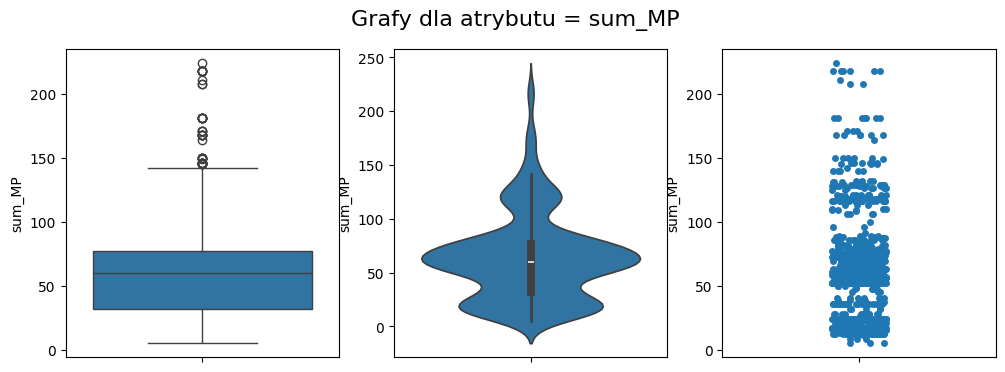

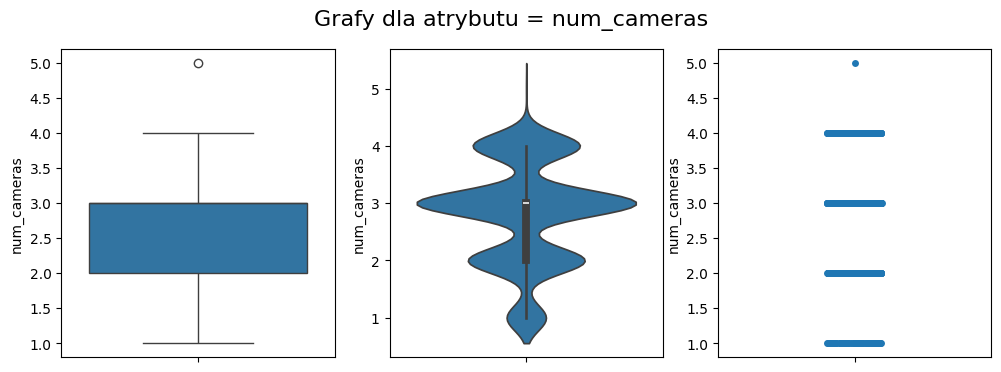

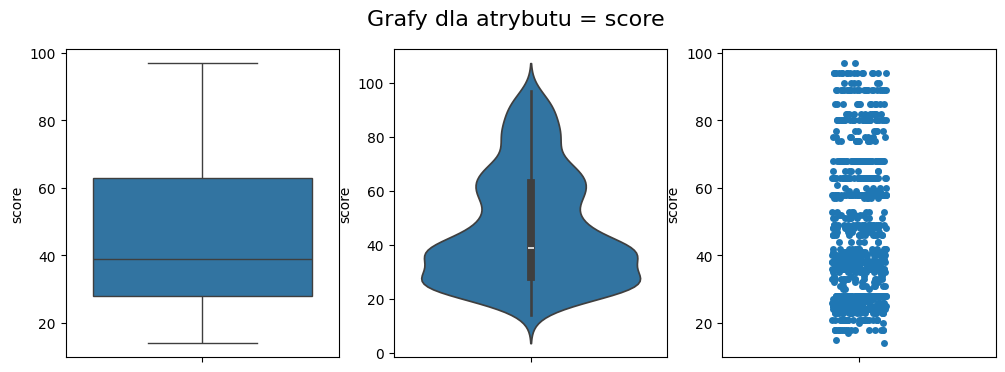

In [34]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df[attr]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary

In [35]:
description = df.describe()
description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,16.349156,4461.768987,6.660865,163.485232,89663.813291,46.027426,2.819620,64.138186,46.607595,6.443776,84.259494
std,8.714250,841.957323,2.797498,121.308480,77488.250242,20.459177,0.872043,40.356998,28.937358,0.422967,27.847301
min,1.000000,3.000000,1.000000,8.000000,399.000000,14.000000,1.000000,5.000000,5.000000,4.000000,60.000000
25%,8.000000,4020.000000,4.000000,128.000000,39999.000000,28.000000,2.000000,32.000000,13.000000,6.400000,60.000000
50%,16.000000,4500.000000,6.000000,128.000000,64999.000000,39.000000,3.000000,60.000000,48.000000,6.530000,60.000000
75%,20.000000,5000.000000,8.000000,256.000000,103499.000000,63.000000,3.000000,77.000000,64.000000,6.670000,120.000000
max,44.000000,7000.000000,16.000000,1024.000000,555999.000000,97.000000,5.000000,224.000000,200.000000,8.010000,144.000000


Zmienność atrybutów

In [36]:
def calculate_coefficient_variation(column):
    return column['std']/column['mean']

description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.533009
battery_capacity    0.188705
ram                 0.419990
internal_storage    0.742015
price               0.864209
score               0.444500
num_cameras         0.309277
sum_MP              0.629220
main_camera         0.620872
screen_size         0.065640
refresh_rate        0.330495
dtype: float64

## Macierz wykresów atrybutów danych

In [37]:
#sns.pairplot(data = df, hue = 'brand_name')

Z powyższej macierzy można zauważyć, że marka APPLE charakteryzuje się mniejszymi pojemnościami baterii i trochę wyższą ceną niż pozostałe marki. Najprawdopodobniej jest to związane z użyciem przez nich własnego systemu operacyjnego, co może wskazywać na użycie osobnego modelu dla właśnie tych smartfonów. Również wśród produktów marki APPLE znajduje się najwięcje smartfonów o mniejszych rozmiarach ekranu.

## Macierz korelacji danych

<Axes: >

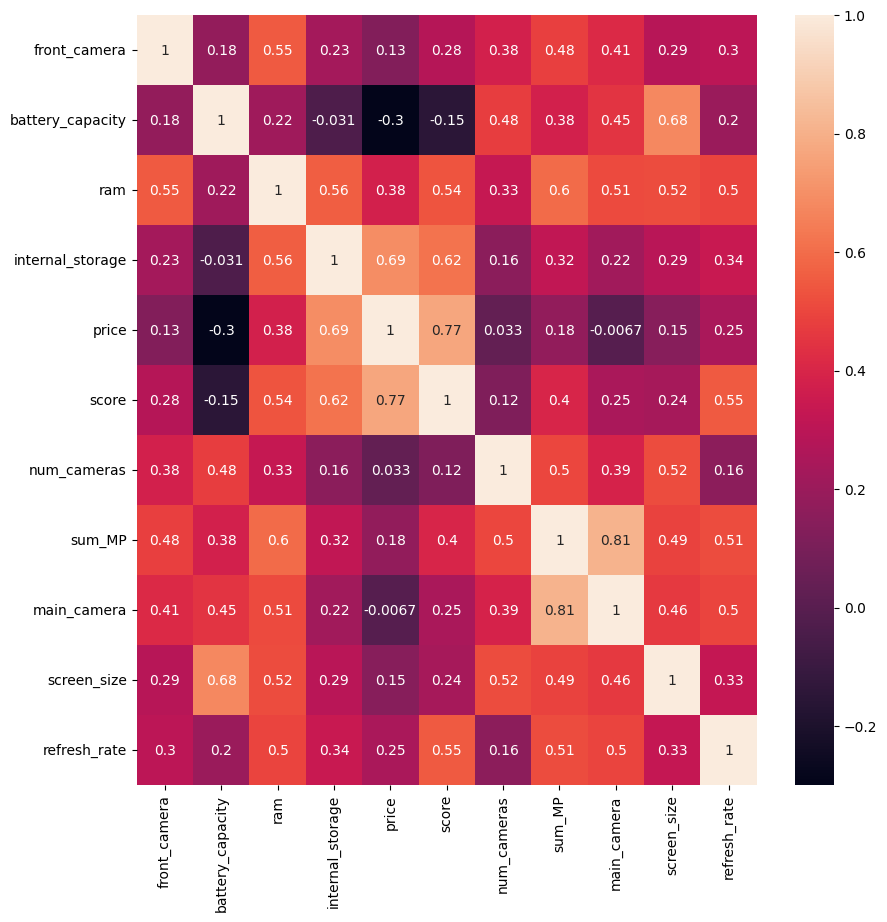

In [38]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

Największy wpływ na cenę ma punktacja na podstawie procesora, jest to mocna korelacja o wartości 0,78. Również dosyć dobrze skorelowane jest atrybut pamięci wewnętrznej, o wartości 0,6. Pozostałe atrybuty nie mają albo żadnego wpływu (korelacja bliska 0), lub bardzo mały wpływ. 
Poza tym najbradziej skorelowanymi ze sobą atrybutami są suma megapikseli i wartość megapikseli dla głównej kamery, ponieważ ta druga wartość stanowi składową pierwszej. Rozmiar ekranu i pojemność baterii również są mocno skorelowane, co jest związane z fizycznym rozmiarem urządzenia. Również ciekawym jest to, że cena i pojemność baterii jest ze sobą ujemnie skorelowana, jest to najprawdopodobniej powiązane z użyciem produktów Apple, które mają mniejszą pojemność baterii, a są widocznie droższe niż większość smartfonów z androidem.
Atrybut, który ma najmniejsza korelację są main_camera i num_cameras, są one bliskie 0. Pozostałymi atrybutami, których korelacja z ceną < 20, są: front_camera, sum_mp, screen_size.

W tym przypadku atrybutami, które jako jedyne mają wpływ są: *score*, *internal_storage*, oraz słaby wpływ: *ram*, *battery_capacity*

Z powodu na słabą korelację atrybutów między sobą i sugerowany wpływ różnic ze względu na smartfony firmy APPLE, myślę, że najlepszym sposobem do uzyskania dobrych rezultatów jest przeprowadzenie analizy jeszcze raz dla podziału na smartfony APPLE i resztę, czyli te z systemem Android

In [39]:
df_apple = df[df['brand_name'] == 'APPLE']
print('Ilość smartfonów z systemem iOS:     ', len(df_apple))
# zresetowanie indeksów
df_apple = df_apple.reset_index()
df_apple = df_apple.drop(columns = ['index'])


df_android = df[df['brand_name'] != 'APPLE']
print('Ilość smartfonów z systemem Android:', len(df_android))
# zresetowanie indeksów
df_android = df_android.reset_index()
df_android = df_android.drop(columns = ['index'])

Ilość smartfonów z systemem iOS:      91
Ilość smartfonów z systemem Android: 857


Po podziale zbiór smartfonów z iOS, jest około 9-10 razy mniejszy zbiór smartfonów z android.

Analiza dla smartfonów Android

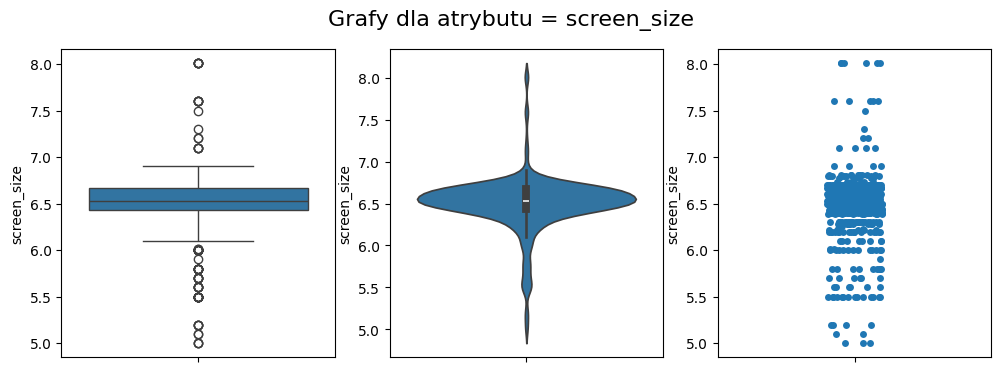

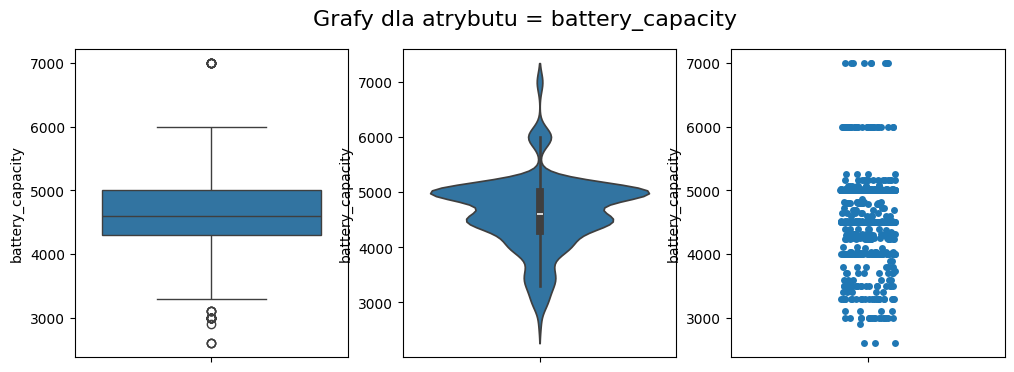

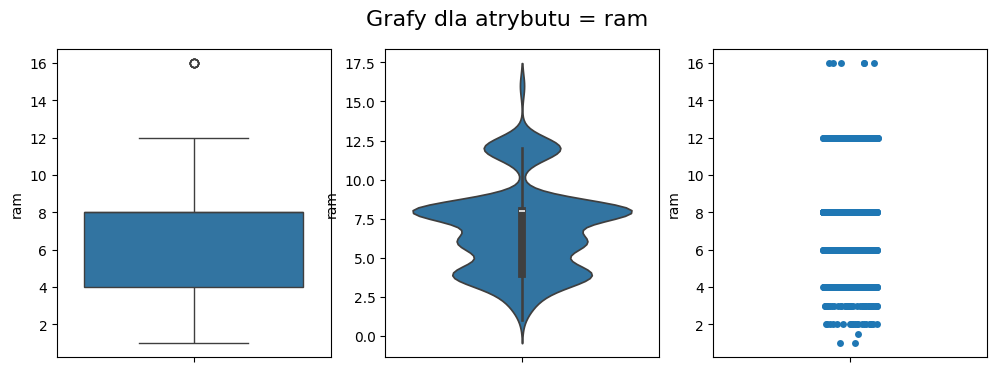

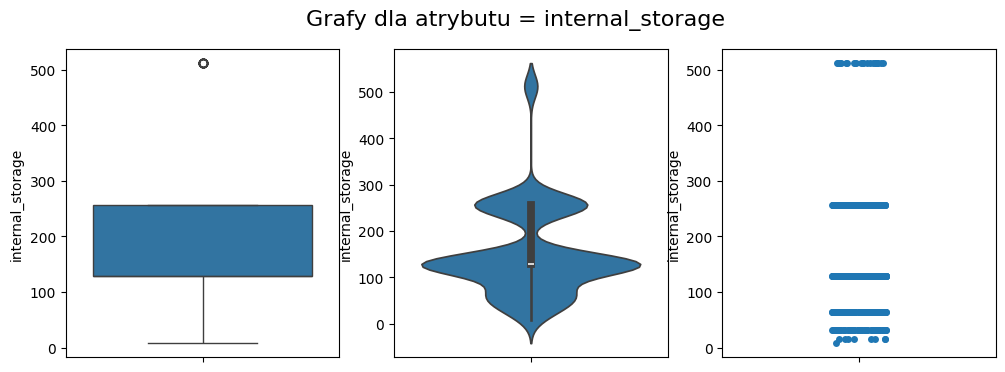

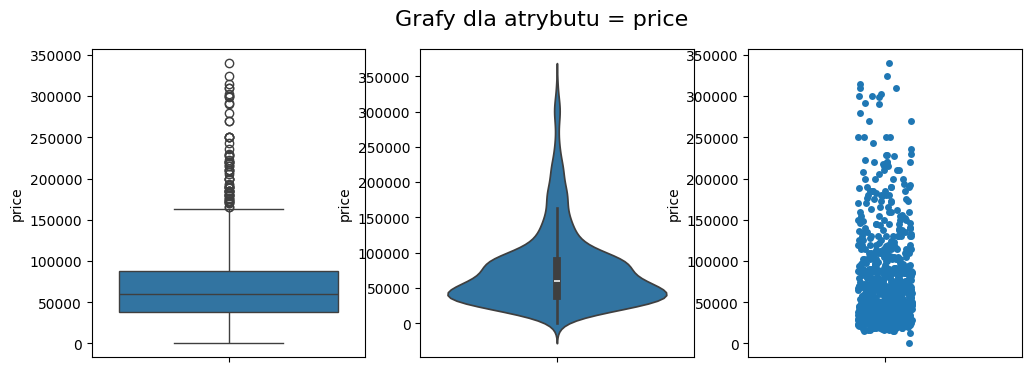

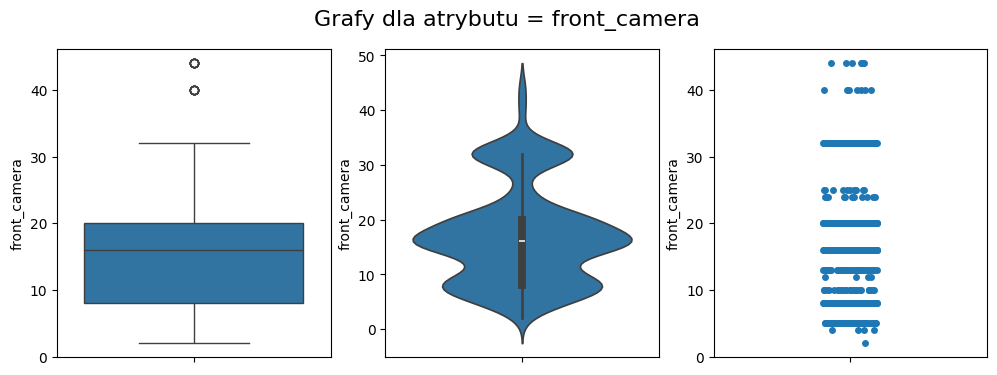

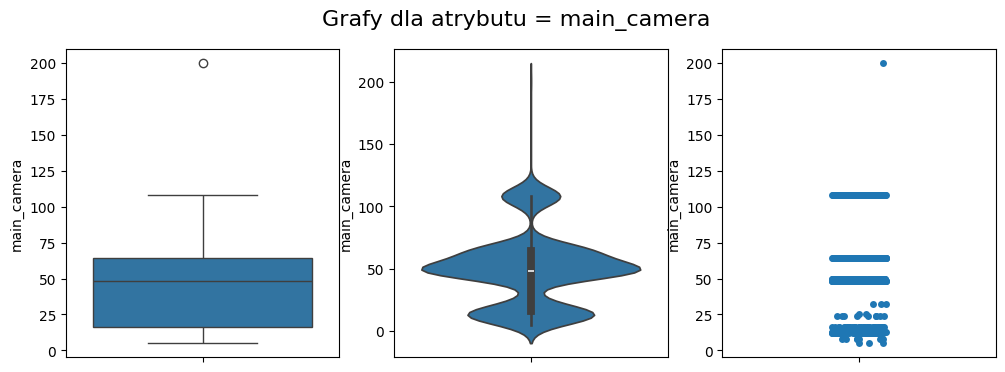

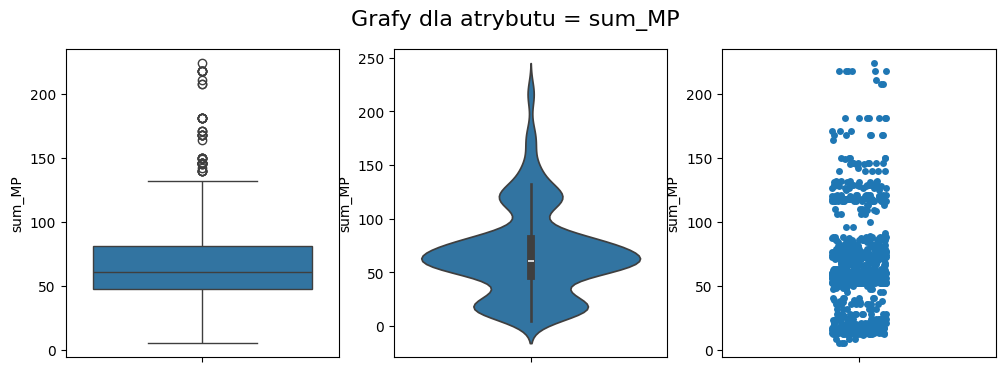

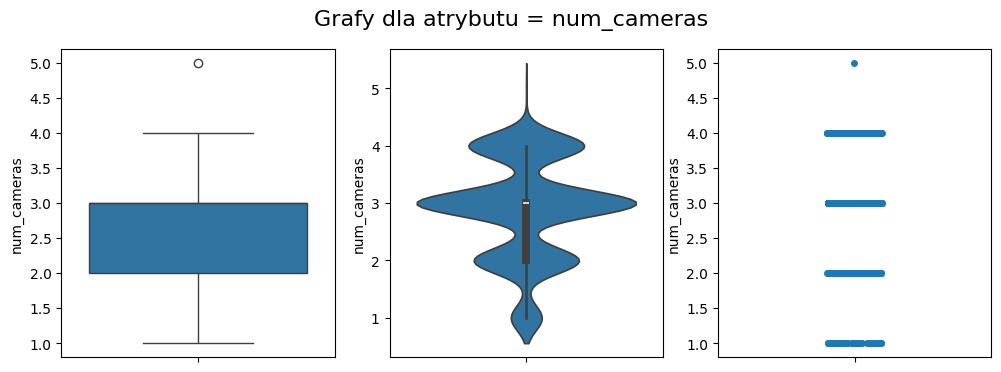

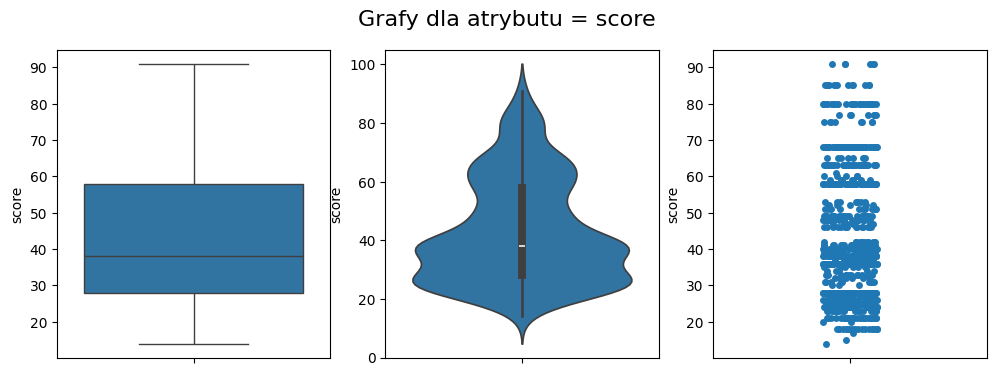

In [40]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df_android[attr]
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary (Android)

In [41]:
android_description = df_android.describe()
android_description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,17.038506,4620.904317,6.890898,153.512252,76135.154026,43.136523,2.893816,67.532089,49.568261,6.500817,85.365228
std,8.835975,664.140733,2.796453,96.039469,55107.838671,17.902678,0.850603,40.509566,28.531346,0.322475,27.878715
min,2.000000,2600.000000,1.000000,8.000000,399.000000,14.000000,1.000000,5.000000,5.000000,5.000000,60.000000
25%,8.000000,4300.000000,4.000000,128.000000,37999.000000,28.000000,2.000000,47.000000,16.000000,6.430000,60.000000
50%,16.000000,4600.000000,8.000000,128.000000,59999.000000,38.000000,3.000000,61.000000,48.000000,6.530000,90.000000
75%,20.000000,5000.000000,8.000000,256.000000,88415.000000,58.000000,3.000000,81.000000,64.000000,6.670000,120.000000
max,44.000000,7000.000000,16.000000,512.000000,339999.000000,91.000000,5.000000,224.000000,200.000000,8.010000,144.000000


Współczynnik zmienności atrybutów

In [42]:
android_description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.518589
battery_capacity    0.143725
ram                 0.405818
internal_storage    0.625614
price               0.723816
score               0.415024
num_cameras         0.293938
sum_MP              0.599857
main_camera         0.575597
screen_size         0.049605
refresh_rate        0.326582
dtype: float64

Macierz korelacji

<Axes: >

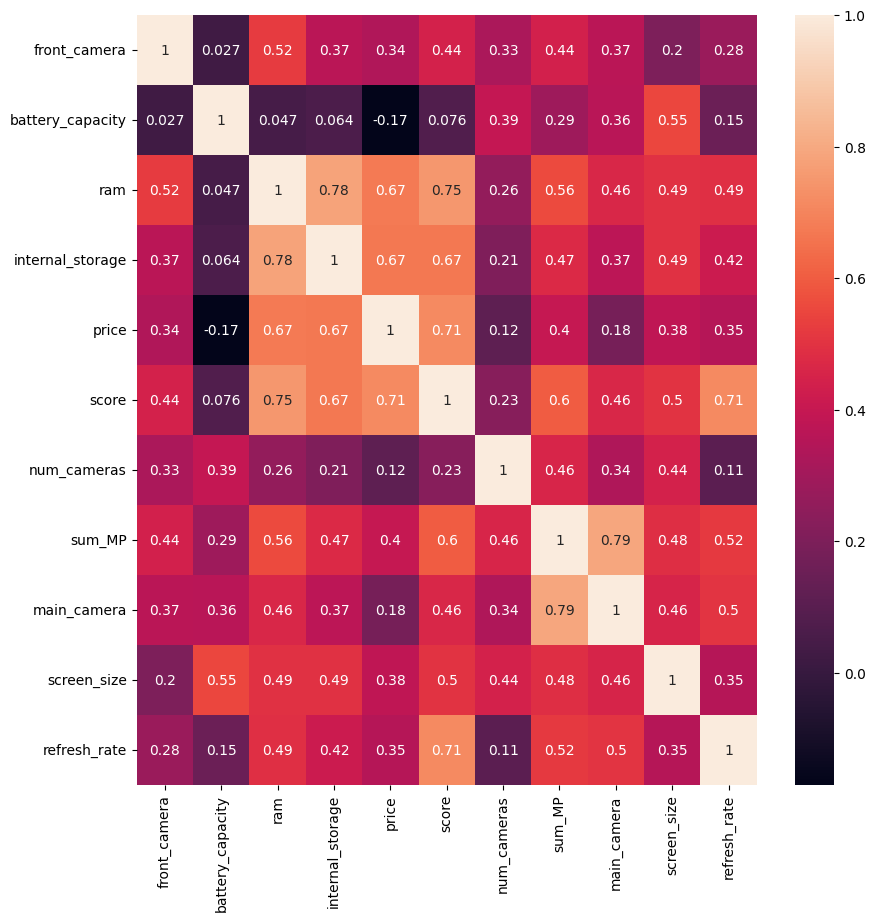

In [43]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

Atrybutami, które mają >= 60 korelację z ceną, są: ram, internal_storage, score. Z tych powyższych możemy użyć atrybutu score i internal_storage, bez atrybutu ram, ze względu na ich mocną korelację z atrybutem ram (0.75 i 0.78).

Pozostałe atrybuty są słabo skorelowane z ceną, przy czym atrybut num_cameras ma bardzo niską korelacje 0.11, przez co nie powinien praktycznie wpływać na rezultat. Najbardziej w zbiorze danych są ze sobą ponownie skorelowane są atrybuty sum_MP i main_camera. 

Dla smartfonów Apple

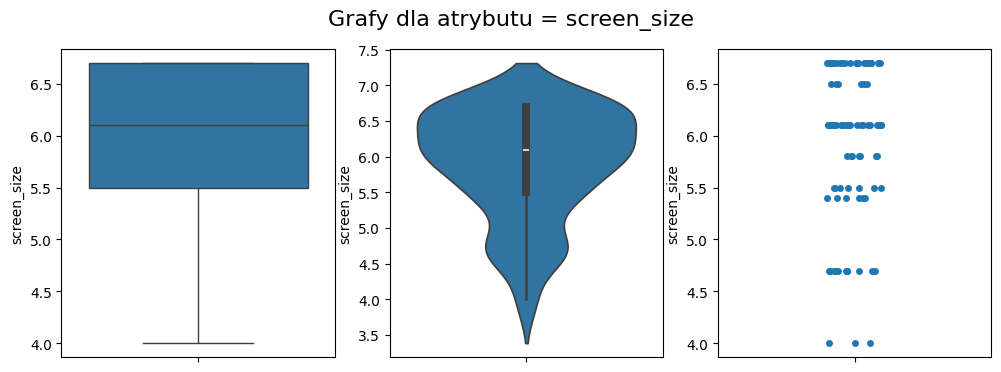

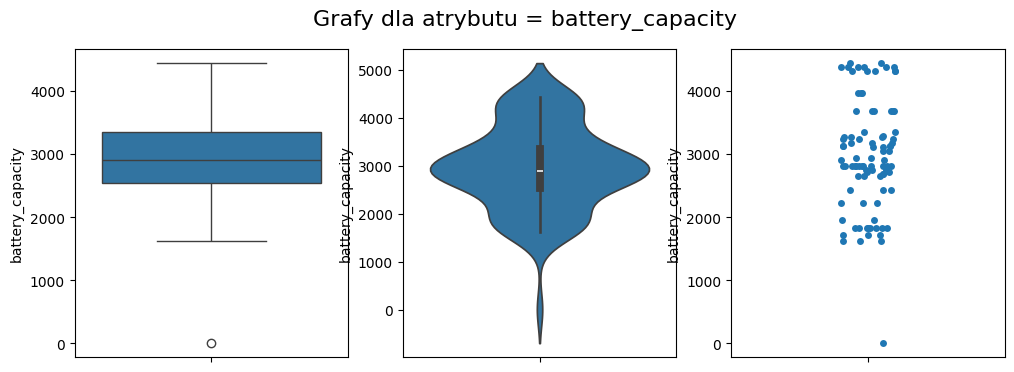

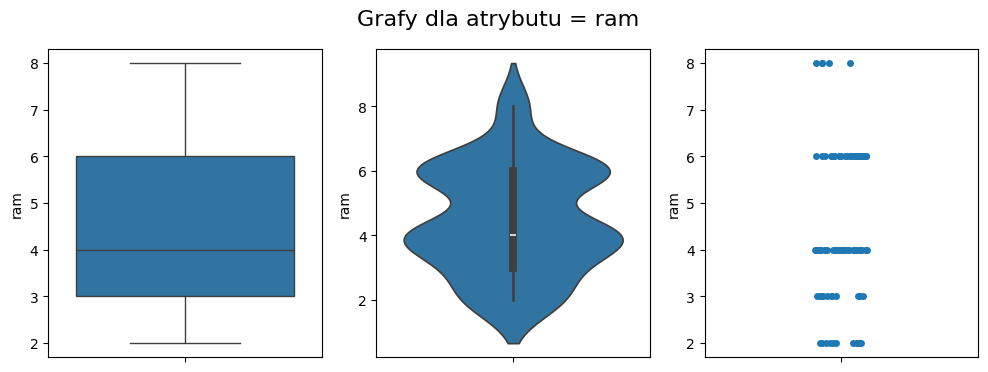

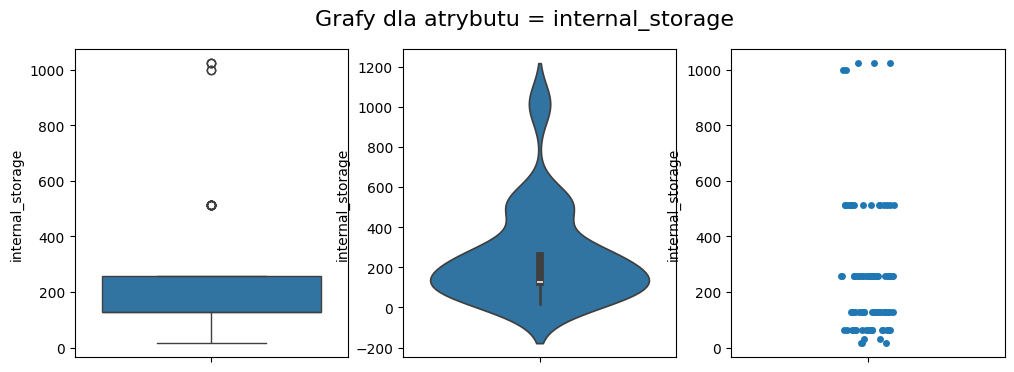

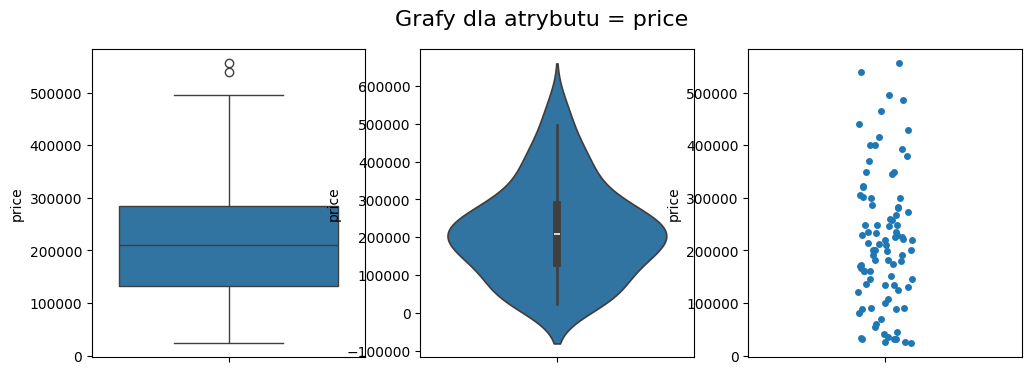

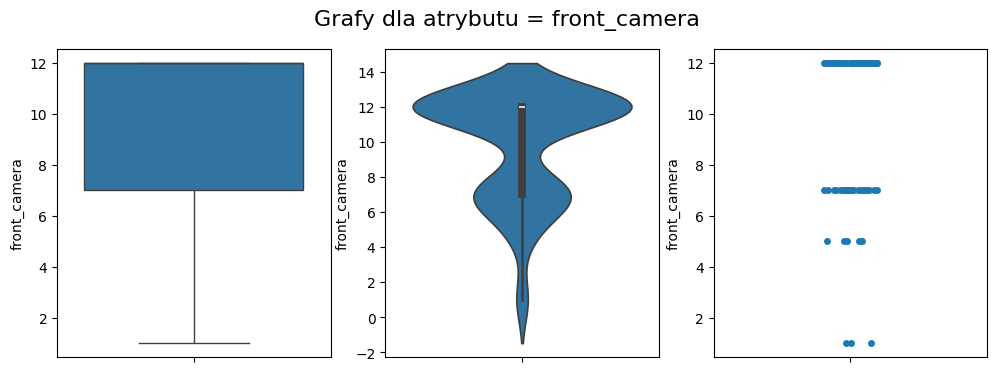

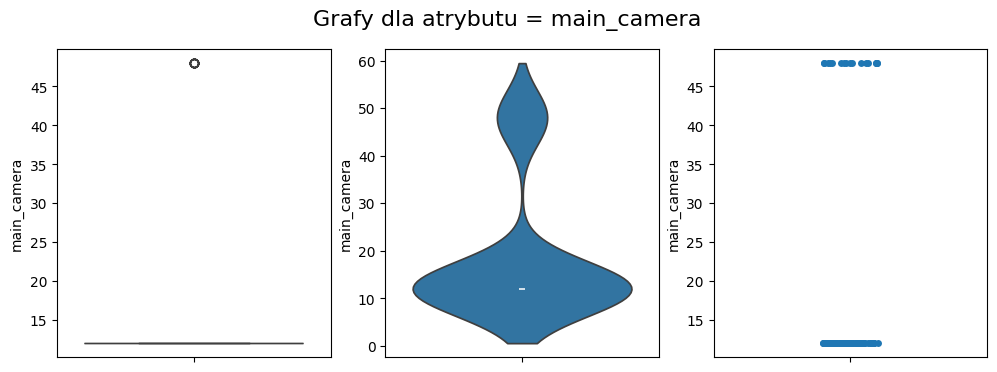

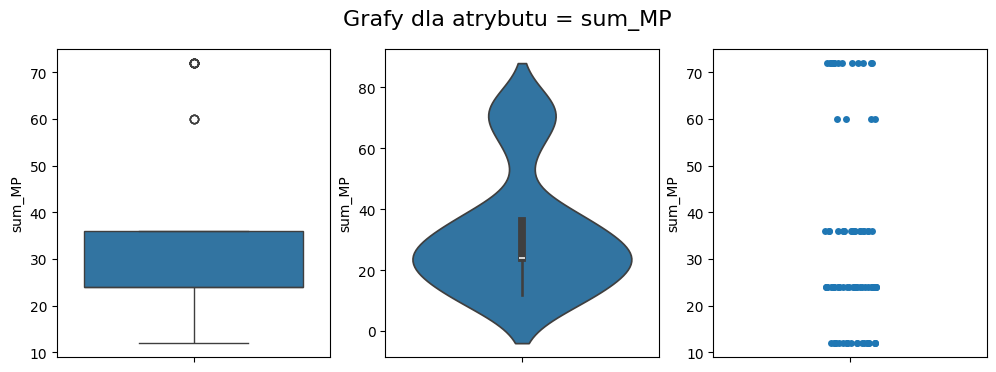

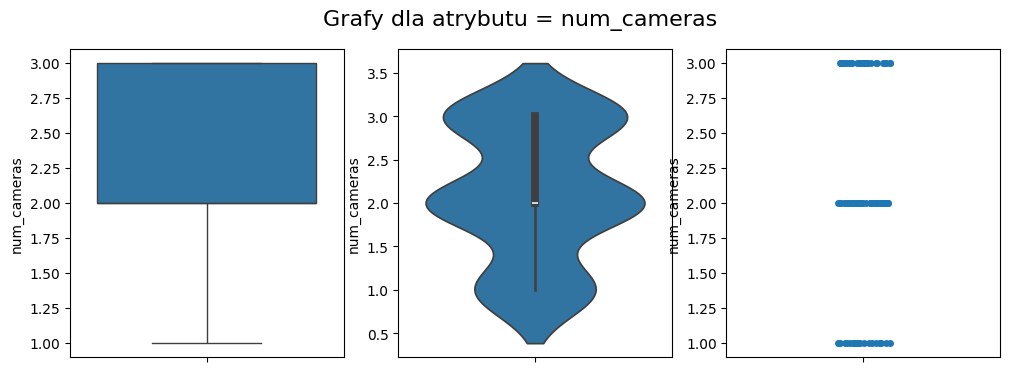

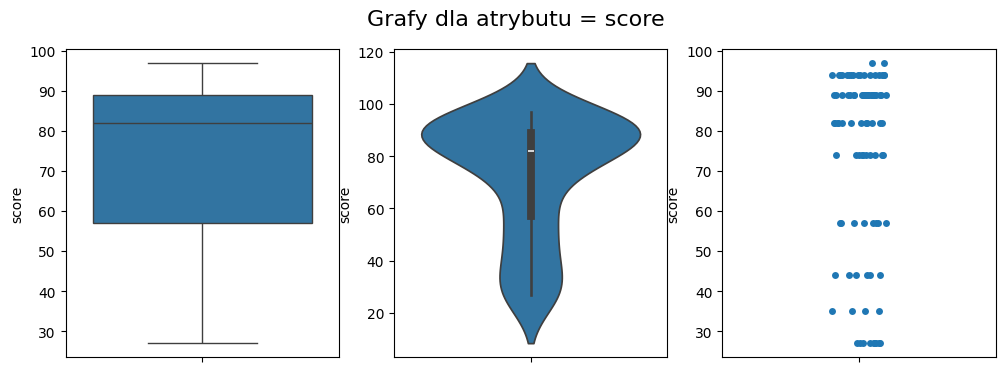

In [44]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras', 'score']:
    dane = df_apple[attr]
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Standardowe miary (Apple)

In [45]:
apple_description = df_apple.describe()
apple_description

,front_camera,battery_capacity,ram,internal_storage,price,score,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,9.857143,2963.098901,4.494505,257.406593,217071.076923,73.252747,2.120879,32.175824,18.725275,5.906593,73.846154
std,3.053491,867.077262,1.649065,239.268793,127043.757238,22.955800,0.757704,19.667567,14.109151,0.755396,25.419556
min,1.000000,3.000000,2.000000,16.000000,22999.000000,27.000000,1.000000,12.000000,12.000000,4.000000,60.000000
25%,7.000000,2548.000000,3.000000,128.000000,132499.000000,57.000000,2.000000,24.000000,12.000000,5.500000,60.000000
50%,12.000000,2900.000000,4.000000,128.000000,209999.000000,82.000000,2.000000,24.000000,12.000000,6.100000,60.000000
75%,12.000000,3349.000000,6.000000,256.000000,284900.000000,89.000000,3.000000,36.000000,12.000000,6.700000,60.000000
max,12.000000,4441.000000,8.000000,1024.000000,555999.000000,97.000000,3.000000,72.000000,48.000000,6.700000,120.000000


Współczynnik zmienności atrybutów

In [46]:
apple_description.apply(calculate_coefficient_variation, axis = 0)

front_camera        0.309774
battery_capacity    0.292625
ram                 0.366907
internal_storage    0.929536
price               0.585263
score               0.313378
num_cameras         0.357259
sum_MP              0.611253
main_camera         0.753482
screen_size         0.127890
refresh_rate        0.344223
dtype: float64

<Axes: >

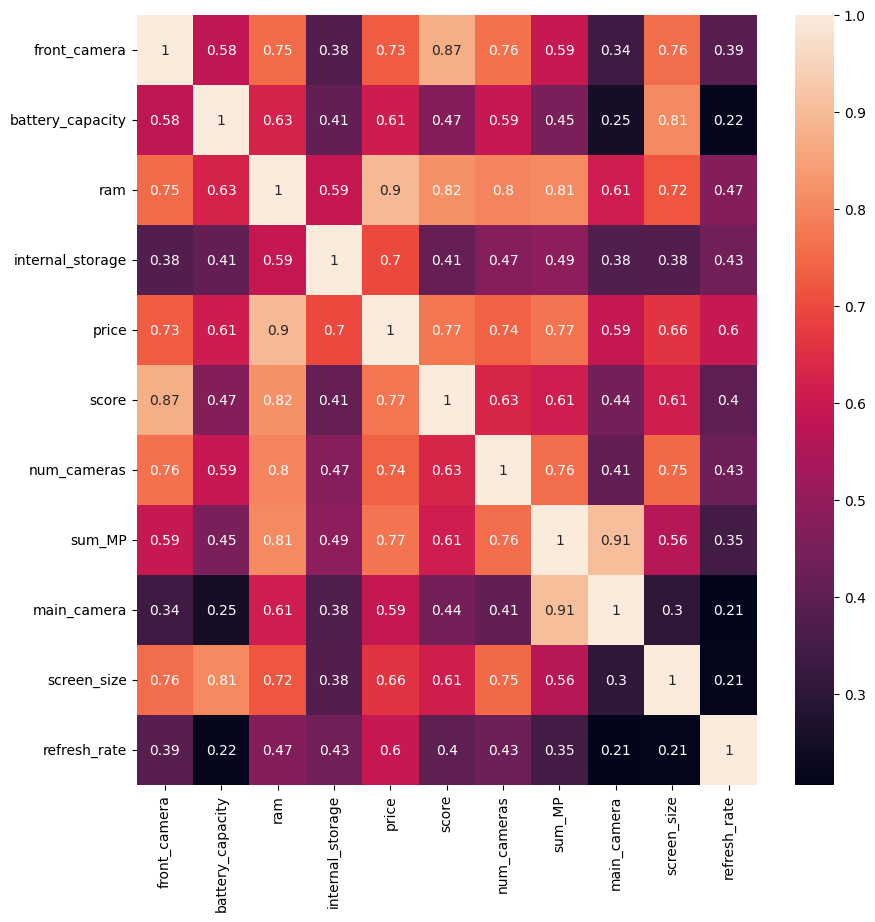

In [47]:
plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr(),annot = df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].corr())

W powyższej macierzy, korelację >= 0.6 z ceną, mają atrybutu: front_camera, battery_capacity, ram, score, num_cameras, sum_MP, screen_size. Ze wględu na mocną korelację niektórych z tych atrybutów z ram można w modelu regresji użyć atrybutów ram, battery_capacity, front_camera.

## Użycie regresji liniowej

In [48]:
def use_regression(df, attributes, dec_attribute, test_size, random = 0, min_max = False, standarization = False, stratify_arg = ""):
    ''' 
    parametry:
        df - ramka danych, która zostanie podzielona na dane uczące i testowe,
        dec_attribute - atrybut decyzujący,
        test_size - rozmiar zbioru testowego, liczba w przedziale (0.0, 1.0>,
        random - wartość seed random_state w funkcji train_test_split,
        max_min - jeżeli True dokonuje normalizacji min_max danych,
        standarization - jeżeli True dokonuje standaryzacji danych
        *uwaga jeżeli param

    zwraca:
        e_train - błąd uczenia,
        e_test - błąd generalizacji
    '''
    df_t = df.loc[:, attributes]

    if min_max == True and standarization == True:
        raise ValueError('Podano wartość min_max == True i standarization == True')

    if min_max == True:
        print('Wykonuję normalizację')
        scaler = MinMaxScaler()
        df_t = scaler.fit_transform(df_t)
    
    if standarization == True:
        print('Wykonuję standaryzację')
        scaler = StandardScaler()
        df_t = scaler.fit_transform(df_t)

    if stratify_arg == "":
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random)
    else:
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random, stratify = df[stratify_arg])

    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    e_train = metrics.mean_squared_error(y_train, y_pred_train)
    y_pred_test = model.predict(x_test)
    e_test = metrics.mean_squared_error(y_test, y_pred_test)
    
    return e_train, e_test

In [49]:
def plot_results(x, dokl_ucz, dokl_test, title, x_label):
    '''
    funkcja odpowiada za wizualizacje dokladnosci uczenia dla danych testowych i uczących
    
    parametry:
        x - dana rozdzielczość, dla której zebrane są dane uczenia
        dokl_ucz - wyniki dokladnosci, dla danych uczących
        dokl_test - wyniki dokladnosci, dla danych testowych
    '''
    plt.figure(dpi=100)
    plt.title(title)
    plt.plot(x, dokl_ucz, 'bo-', label = 'dane uczące')
    plt.xlabel(x_label)
    plt.ylabel('Błąd')
    plt.plot(x, dokl_test, 'ro-', label = 'dane testowe')
    plt.legend(loc='center right')
    plt.show()

Funkcja klasyfikująca do grup, w zależności od ceny. Jest ona wymagana przy użyciu stratify w funkcji train_test_split, aby podzielić dane testowe i treningowe w równych proporcjach co do ich wartości

In [50]:
def classify_based_on_price(row, bins, attribute):
    for i in range(len(bins)):
        if (row[attribute] >= bins[i]):
            return i
    return -1                                # returns where there is an error

Wszystkie atrybuty numeryczne:

In [51]:
all_attributes = ['front_camera', 'battery_capacity', 'ram', 'internal_storage', 'score', 'num_cameras', 'sum_MP', 'main_camera', 'screen_size', 'refresh_rate']

### Dla całego zbioru danych, bez podziału

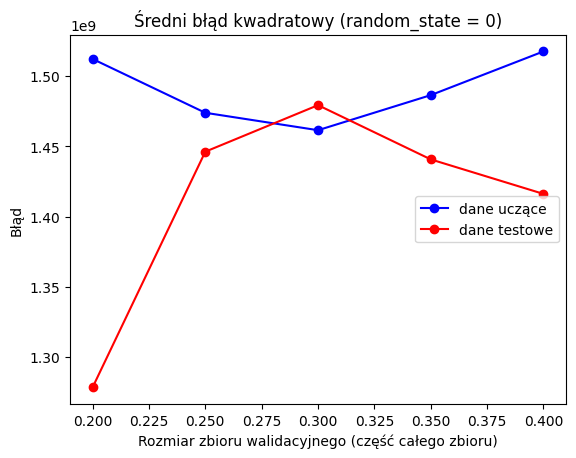

Minimalny błąd dla zbioru testowego = 1278390738.9065156 dla rozmiaru danych testowych = 0.2


In [52]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Proporcjonalny podział danych testowych i uczących

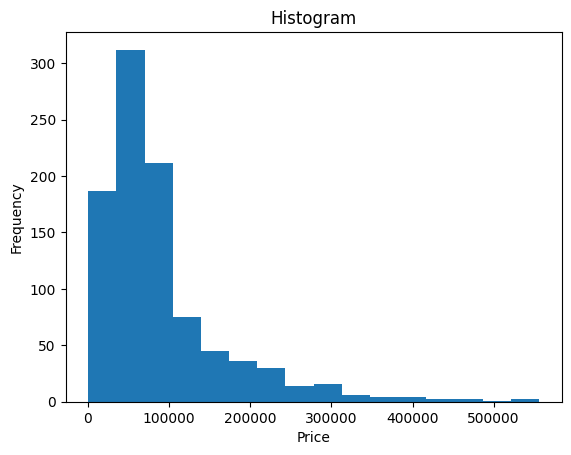

Błąd uczenia:       1490851628.518541
Błąd generalizacji: 1351625300.6490738


In [53]:
samples_per_bin, bins = np.histogram(df['price'], bins='doane')
bins = bins[:-2]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

plt.hist(df['price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram')
 
# Display the plot
plt.show()

df['classification'] = df.apply(classify_based_on_price, axis = 1, args = [bins, 'price'])

[e_train, e_test] = use_regression(df, all_attributes, 'price', 0.2, stratify_arg = 'classification')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

[187 312 212  75  45  36  30  14  16   6   4   4   2   2   1   2]
[3.99000e+02 3.51240e+04 6.98490e+04 1.04574e+05 1.39299e+05 1.74024e+05
 2.08749e+05 2.43474e+05 2.78199e+05 3.12924e+05 3.47649e+05 3.82374e+05
 4.17099e+05 4.51824e+05 4.86549e+05 5.21274e+05 5.55999e+05]


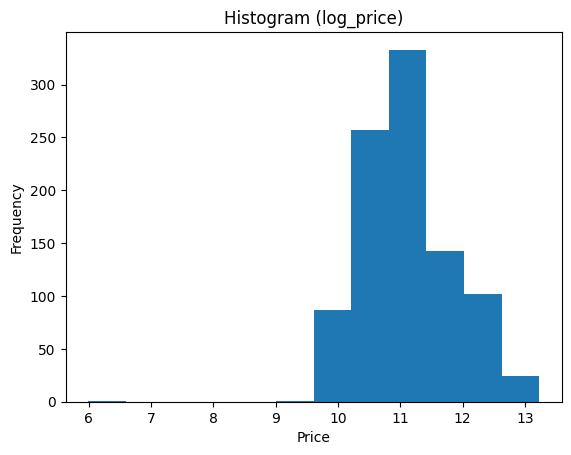

Błąd uczenia:       1399784558.4639611
Błąd generalizacji: 1711959379.3468924


In [54]:
df['log_price'] = np.log(df['price'])
samples_per_bin, bins = np.histogram(df['price'], bins='doane')
print(samples_per_bin)
print(bins)

plt.hist(df['log_price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (log_price)')
 
# Display the plot
plt.show()

df['class'] = df.apply(classify_based_on_price, axis = 1, args = [bins, 'log_price'])

[e_train, e_test] = use_regression(df, all_attributes, 'price', 0.2, stratify_arg = 'class')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Nie poprawiło to rezultatów błędu generalizacji

Wybór parametru random

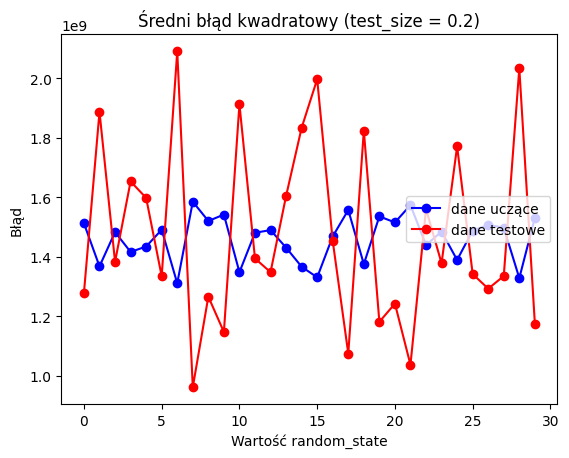

Minimalny błąd dla zbioru testowego = 960677136.3914217 dla wartości random_state = 7


In [55]:
r = range(30)
error_train = []
error_test = []
for random in range(30):
    [e_train, e_test] = use_regression(df, all_attributes, 'price', 0.2, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

test_size = 0.2

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

In [56]:
print('Normalizacja Min-Max')
[e_train_norm, e_test_norm] = use_regression(df, all_attributes, 'price', 0.2, random = 7, min_max = True)
print('Błąd uczenia      ', e_train_norm)
print('Błąd generalizacji', e_test_norm)
print()

print('Standaryzacja')
[e_train_stand, e_test_stand] = use_regression(df, all_attributes, 'price', 0.2, random = 7, standarization = True)
print('Błąd uczenia      ', e_train_stand)
print('Błąd generalizacji', e_test_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1585206881.1838653
Błąd generalizacji 960677136.3914188

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1585206881.1838648
Błąd generalizacji 960677136.391422


Zarówno normalizacja Min-Max, jak i standaryzacja nie dają lepszych rezultatów.

### Apple

Wybranie parametru test_size, do jak najlepszego podziału zbioru

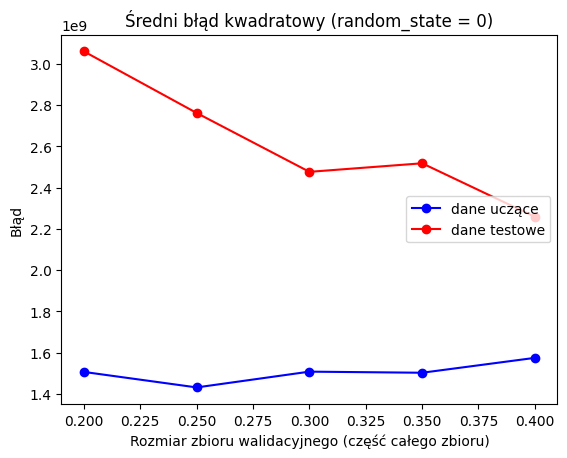

Minimalny błąd dla zbioru testowego = 2259059572.363845 dla rozmiaru danych testowych = 0.4


In [57]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df_apple, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Proporcjonalny podział danych testowych i uczących

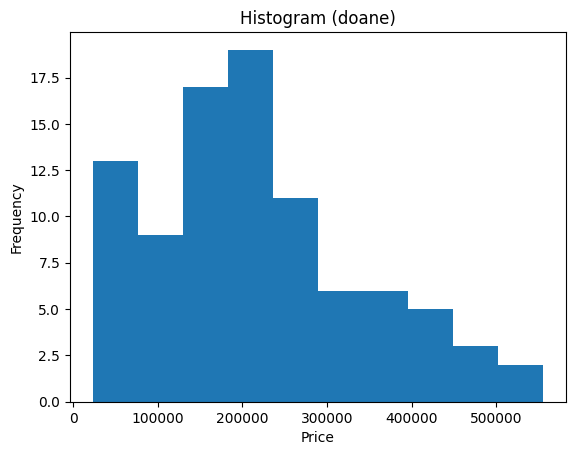

Błąd uczenia:       1431061590.6360517
Błąd generalizacji: 2712255908.1419845


In [58]:
samples_per_bin, bins = np.histogram(df_apple['price'])
bins = bins[:-1]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

plt.hist(df_apple['price'], bins = 'doane')

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (doane)')
 
# Display the plot
plt.show()

df_apple['classification'] = df_apple.apply(classify_based_on_price, axis = 1, args = [bins, 'price'])

[e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.4, stratify_arg = 'classification')

print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Logarytmowanie ceny 

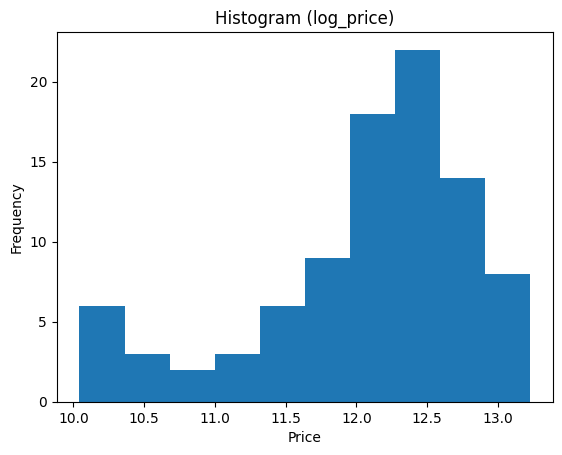

Błąd uczenia:       1420150693.13585
Błąd generalizacji: 2475498150.177466


In [59]:
df_apple['log_price'] = np.log(df_apple['price'])
samples_per_bin, bins = np.histogram(df_apple['price'], bins='doane')

plt.hist(df_apple['log_price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (log_price)')
 
# Display the plot
plt.show()


df_apple['class'] = df_apple.apply(classify_based_on_price, axis = 1, args = [bins, 'log_price'])

[e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.4, stratify_arg = 'class')

print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Proporcjonalny podział danych praktycznie nie poprawił wyniku błędu generalizacji

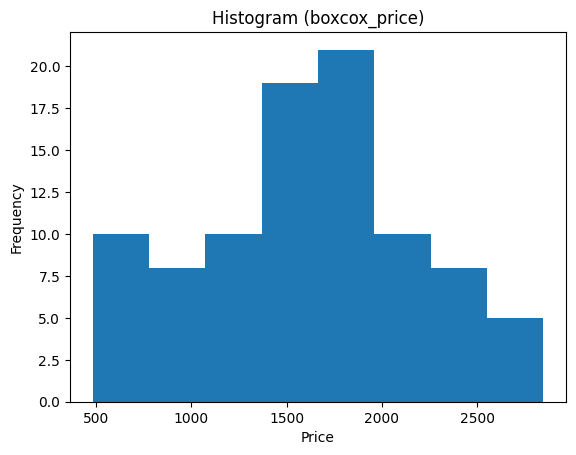

Błąd uczenia:       1313011172.6425936
Błąd generalizacji: 2711381893.665036


In [60]:
from scipy.stats import boxcox

[df_apple['boxcox_price'], best_lambda] = boxcox(df_apple['price'])
samples_per_bin, bins = np.histogram(df_apple['boxcox_price'], bins='doane')

bins = bins[:-1]
bins = bins[::-1]

plt.hist(df_apple['boxcox_price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (boxcox_price)')
 
# Display the plot
plt.show()


df_apple['class'] = df_apple.apply(classify_based_on_price, axis = 1, args = [bins, 'boxcox_price'])

[e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.4, stratify_arg = 'class')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Wybranie parametru random

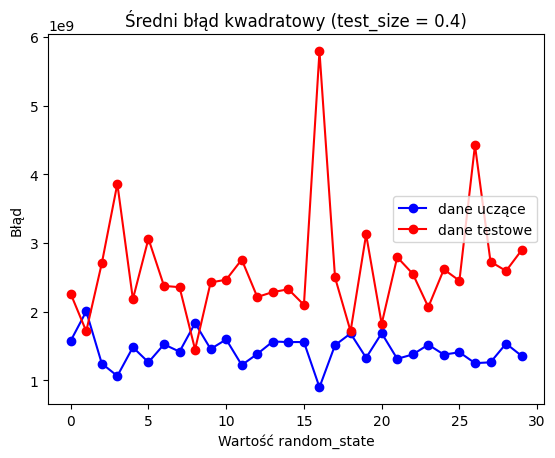

Minimalny błąd dla zbioru testowego = 1447671373.44209 dla wartości random_state = 8


In [61]:
r = range(30)
error_train = []
error_test = []
for random in range(30):
    [e_train, e_test] = use_regression(df_apple, all_attributes, 'price', 0.4, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

test_size = 0.4

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

In [62]:
print('Normalizacja Min-Max')
[e_train_apple_norm, e_test_apple_norm] = use_regression(df_apple, all_attributes, 'price', 0.4, random = 8, min_max = True)
print('Błąd uczenia      ', e_train_apple_norm)
print('Błąd generalizacji', e_test_apple_norm)
print()

print('Standaryzacja')
[e_train_apple_stand, e_test_apple_stand] = use_regression(df_apple, all_attributes, 'price', 0.4, random = 8, standarization = True)
print('Błąd uczenia      ', e_train_apple_stand)
print('Błąd generalizacji', e_test_apple_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1831581017.2893655
Błąd generalizacji 1447671373.4420555

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1831581017.2893665
Błąd generalizacji 1447671373.4420562


Zarówno normalizacja Min-Max, jak i standaryzacja nie dały lepszych rezultatów.

### Android

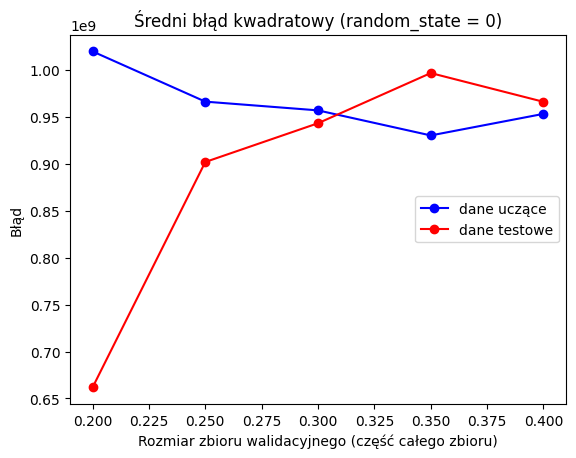

Minimalny błąd dla zbioru testowego = 661754457.590953 dla rozmiaru danych testowych = 0.2


In [63]:
error_train = []
error_test = []
test_size = [0.2, 0.25, 0.3, 0.35, 0.4]
for size in test_size:
    [e_train, e_test] = use_regression(df_android, all_attributes, 'price', size)
    error_train.append(e_train)
    error_test.append(e_test)

random = 0

title = 'Średni błąd kwadratowy (random_state = ' + str(random) + ')'
x_label = 'Rozmiar zbioru walidacyjnego (część całego zbioru)'
plot_results(test_size, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla rozmiaru danych testowych =', test_size[error_test.index(min(error_test))])

Dokonanie proporcjonalnego podziału zbioru danych uczących i testowych

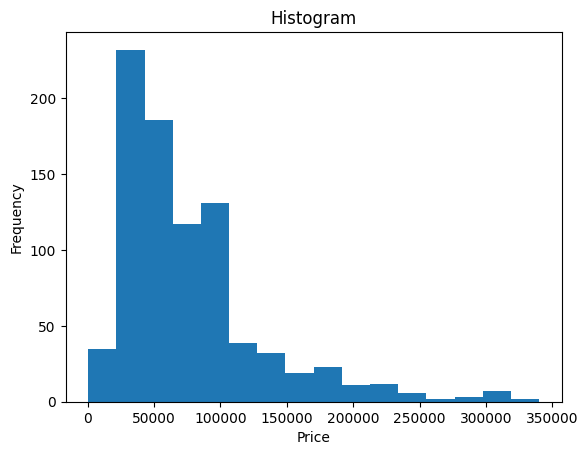

Błąd uczenia:       990752698.967503
Błąd generalizacji: 791907037.2283602


In [64]:
samples_per_bin, bins = np.histogram(df_android['price'], bins='doane')
bins = bins[:-1]   # aby pozbyć się jednoosobowej grupy
bins = bins[::-1]  # odwrócenie wartości w liście

plt.hist(df_android['price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram')
 
# Display the plot
plt.show()

df_android['classification'] = df_android.apply(classify_based_on_price, axis = 1, args = [bins, 'price'])

[e_train, e_test] = use_regression(df_android, all_attributes, 'price', 0.2, stratify_arg = 'classification')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

[  1   0   0   0   0   0   2  66 198 235 232  86  37]
[ 5.98896142  6.50801807  7.02707473  7.54613139  8.06518804  8.5842447
  9.10330136  9.62235801 10.14141467 10.66047133 11.17952798 11.69858464
 12.2176413  12.73669796]
[  1   0   0   0   0   0   2  66 198 235 232  86  37]
[12.2176413  11.69858464 11.17952798 10.66047133 10.14141467  5.98896142
  9.10330136  8.5842447   8.06518804  7.54613139  7.02707473  6.50801807
  5.98896142]


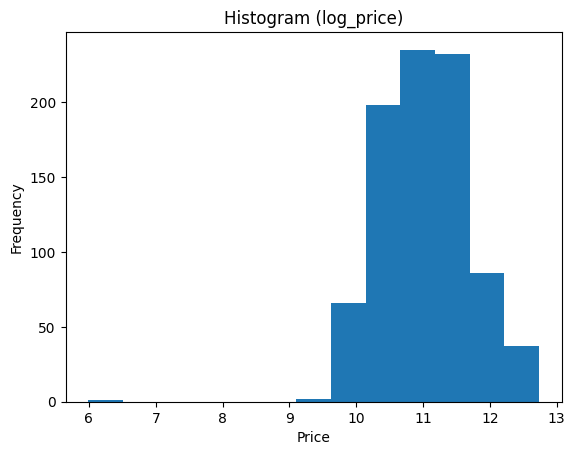

Błąd uczenia:       908852461.8006672
Błąd generalizacji: 1112111966.4253335


In [65]:
df_android['log_price'] = np.log(df_android['price'])
samples_per_bin, bins = np.histogram(df_android['log_price'], bins='doane')
print(samples_per_bin)
print(bins)

bins = bins[:-1]
bins[7] = bins[0]
bins = bins[::-1]

print(samples_per_bin)
print(bins)

plt.hist(df_android['log_price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (log_price)')
 
# Display the plot
plt.show()


df_android['class'] = df_android.apply(classify_based_on_price, axis = 1, args = [bins, 'log_price'])

[e_train, e_test] = use_regression(df_android, all_attributes, 'price', 0.2, stratify_arg = 'class')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

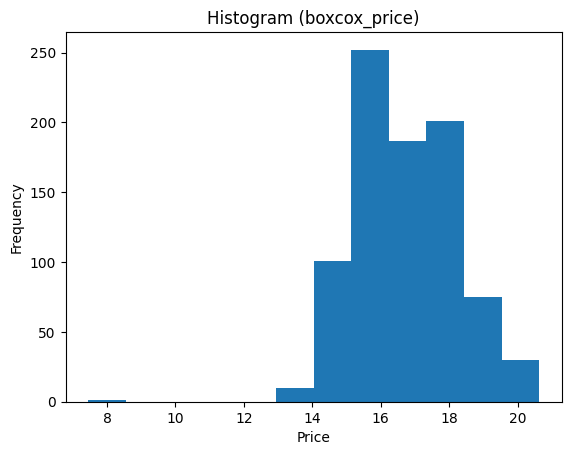

Błąd uczenia:       956072424.3528342
Błąd generalizacji: 932380436.8388054


In [66]:
from scipy.stats import boxcox

[df_android['boxcox_price'], best_lambda] = boxcox(df_android['price'])
samples_per_bin, bins = np.histogram(df_android['boxcox_price'], bins='doane')

bins = bins[:-1]
bins[5] = bins[0]
bins = bins[::-1]

plt.hist(df_android['boxcox_price'], bins = 'doane')
 
# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram (boxcox_price)')
 
# Display the plot
plt.show()


df_android['class'] = df_android.apply(classify_based_on_price, axis = 1, args = [bins, 'boxcox_price'])

[e_train, e_test] = use_regression(df_android, all_attributes, 'price', 0.2, stratify_arg = 'class')
print('Błąd uczenia:      ', e_train)
print('Błąd generalizacji:', e_test)

Dzięki proporcjonalnemu podziałowi błąd generalizacji nie zmniejszył się

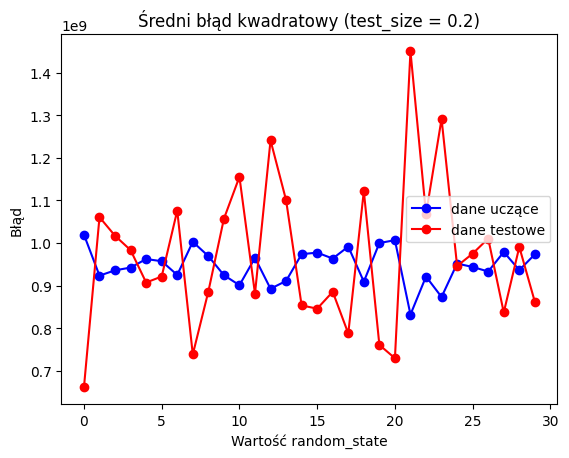

Minimalny błąd dla zbioru testowego = 661754457.590953 dla wartości random_state = 0


In [67]:
r = range(30)
error_train = []
error_test = []
test_size = 0.2
for random in r:
    [e_train, e_test] = use_regression(df_android, all_attributes, 'price', test_size, random = random)
    error_train.append(e_train)
    error_test.append(e_test)

title = 'Średni błąd kwadratowy (test_size = ' + str(test_size) + ')'
x_label = 'Wartość random_state'
plot_results(r, error_train, error_test, title, x_label)
print('Minimalny błąd dla zbioru testowego =', min(error_test), 'dla wartości random_state =', r[error_test.index(min(error_test))])

Jednak dzięki wykorzystaniu innej wartości random_state przy podziale udało się jeszcze bardziej zmniejszyć wartość błędu.

Sprawdzenie zmiany względem normalizacji min-max i standaryzacji danych:

In [68]:
print('Normalizacja Min-Max')
[e_train_android_norm, e_test_android_norm] = use_regression(df_android, all_attributes, 'price', 0.2, random = 0, min_max = True)
print('Błąd uczenia      ', e_train_android_norm)
print('Błąd generalizacji', e_test_android_norm)
print()

print('Standaryzacja')
[e_train_android_stand, e_test_android_stand] = use_regression(df_android, all_attributes, 'price', 0.2, random = 0, standarization = True)
print('Błąd uczenia      ', e_train_android_stand)
print('Błąd generalizacji', e_test_android_stand)

Normalizacja Min-Max
Wykonuję normalizację
Błąd uczenia       1019806307.6880887
Błąd generalizacji 661754457.5909523

Standaryzacja
Wykonuję standaryzację
Błąd uczenia       1019806307.6880884
Błąd generalizacji 661754457.5909526


Zarówno normalizacja Min-Max, jak i standaryzacja danych nie dały lepszych rezultatów

### Przeliczenie w celu porównania rozdzielenia zbioru danych

In [69]:
test_error         = 960677136.3914217
apple_test_error   = 1447671373.44209
android_test_error = 661754457.590953

n_apple = len(df_apple)
n_android = len(df_android)
test_error_splitted = (n_apple*apple_test_error + n_android*android_test_error)/(n_apple + n_android)
print('Całkowity błąd przy rozdzieleniu danych', test_error_splitted)
print('Jest on o', 1 - test_error_splitted/test_error, '% mniejszy od błędu przed rozdzieleniem danych')

Całkowity błąd przy rozdzieleniu danych 737195849.3024018
Jest on o 0.23262892247907507 % mniejszy od błędu przed rozdzieleniem danych


Jak można zauważyć rozdzielenie danych na dwa zbiory, w zależnosci od systemu operacyjnego było dobrym rozwiązaniem

## Zapisa modeli w pliku binarnym

In [70]:
def save_model(df, attributes, dec_attribute, test_size, random = 0, min_max = False, standarization = False, stratify_arg = ""):
    ''' 
    parametry:
        df - ramka danych, która zostanie podzielona na dane uczące i testowe,
        dec_attribute - atrybut decyzujący,
        test_size - rozmiar zbioru testowego, liczba w przedziale (0.0, 1.0>,
        random - wartość seed random_state w funkcji train_test_split,
        max_min - jeżeli True dokonuje normalizacji min_max danych,
        standarization - jeżeli True dokonuje standaryzacji danych

    zwraca:
        model - wytrenowany względem użytych parametrów model regresji liniowej
    '''
    df_t = df.loc[:, attributes]

    if min_max == True and standarization == True:
        raise ValueError('Podano wartość min_max == True i standarization == True')

    if min_max == True:
        print('Wykonuję normalizację')
        scaler = MinMaxScaler()
        df_t = scaler.fit_transform(df_t)
    
    if standarization == True:
        print('Wykonuję standaryzację')
        scaler = StandardScaler()
        df_t = scaler.fit_transform(df_t)

    if stratify_arg == "":
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random)
    else:
        x_train, x_test, y_train, y_test = train_test_split(df_t, df[dec_attribute], test_size = test_size, random_state = random, stratify = df[stratify_arg])

    model = LinearRegression()
    model.fit(x_train, y_train)
    
    return model

In [71]:
pickle.dump(save_model(df_apple, all_attributes, 'price', 0.4, random = 8), open("apple_model.pkl", "wb"))
pickle.dump(save_model(df_android, all_attributes, 'price', 0.2, random = 0), open("android_model.pkl", "wb"))